In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
from numpy import array
%matplotlib inline

In [3]:
# build filter bank convolution kernels
def build_filters():
    filters = []
    ksize = 31
    PI = np.pi
    kernel_params = []
    results = []
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_64F)
        #ksize = 11
        #theta = m*PI/8
        #lambd = 16/3
        #sigma = (5.09030 * 8.0) / (3.0 * PI)
        #gamma = 0.5890
        #psi = 1
        #kern = cv2.getGaborKernel(ksize = (ksize,ksize), sigma = sigma, 
        #        theta= theta, lambd = lambd, 
        #                        gamma = gamma, psi = psi)
        kern /= 1.5*kern.sum()

        params = 'theta=%d,\nksize=%d' % (theta * 180 / np.pi, ksize)
        kernel_params.append(params)
        filters.append((kern,theta))

    return filters
   
 
#Filtering of images here
def process(img, filters):
    accum = np.zeros_like(img)
    all_filtered = []
    
    kern_max = np.zeros_like(filters[0])
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        # returning all the filtered images here
        all_filtered.append((fimg,kern))
        # find maximum element wise and accumulate it in accum
        accum_temp = np.maximum(accum, fimg)
        
        if np.not_equal(accum_temp,accum).any():
            kern_max = kern
            accum = accum_temp
    
    return (accum, kern_max)
 
    
    


## Filter results per image

In [4]:
def process_by_image(img, filters):

    n_row= len(filters)
    imR, imC, imS = img.shape
    
    all_filtered = np.zeros((1,imR,imC,imS),dtype=int)
    
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        all_filtered = np.append(all_filtered,[fimg],axis=0)
    
    # all_filterd :  filtered result for all filters; find the max next
    
    all_filtered = all_filtered[1:]
    #max_resp is a tuple with all filtered image and kernal that gives the best result
    max_resp = max_response(all_filtered)
    return max_resp

In [5]:
def max_response(all_filtered):
   
    filtered_sum = all_filtered.sum(axis=(1,2,3))
    kern_ind = filtered_sum.argmax()
    return (all_filtered, kern_ind)

In [6]:
def process_by_filter(imgs, filter):
    all_filtered = [] # filter followed by the images
    all_filtered.append(filter)
 
    for im in imgs:
        fimg = cv2.filter2D(im, cv2.CV_8UC3, filter)
        all_filtered.append(fimg)
        
    return all_filtered

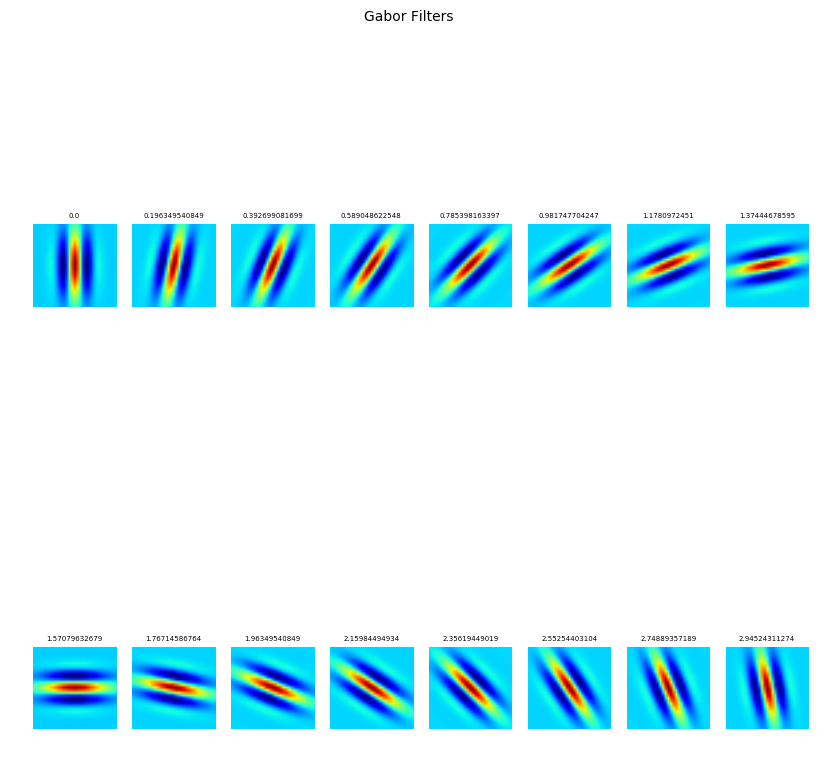

In [7]:
img_1 = cv2.imread('H4.tiff')
img_2 = cv2.imread('H20.tiff')
img_3 = cv2.imread('I65.tiff')
img_4 = cv2.imread('I200.tiff')

image_names = ('H4', 'H20', 'I65', 'I200')

images = (img_1, img_2, img_3, img_4)

#img = cv2.imread(img_fn)
filters_res = build_filters()
filters = []

for i in filters_res:
    filters.append(i[0])

flen = len(filters)

fig_fil, axes_fil = plt.subplots(nrows=2, ncols=flen/2 ,figsize=(10, 10))
axes_fil[0][0].axis('off')

fig_fil.suptitle('Gabor Filters', fontsize=10)

for i, image1 in enumerate(filters):
    ax = axes_fil.flat[i]
    ax.set_title(filters_res[i][1],fontsize=5)
    ax.imshow(image1)
    ax.axis('off')

In [8]:
#process by filter
f_imgs = []
for f in filters:
    f_imgs.append(process_by_filter(images,f))
    

In [14]:
results = []
#f_img = process(img_4, filters)
for i in images:
    fimg = process(i, filters)
    results.append(fimg)

In [15]:
results_by_image = []
for i in images:
    fimg = process_by_image(i, filters)
    results_by_image.append(fimg)

### Display filtered images and the best result

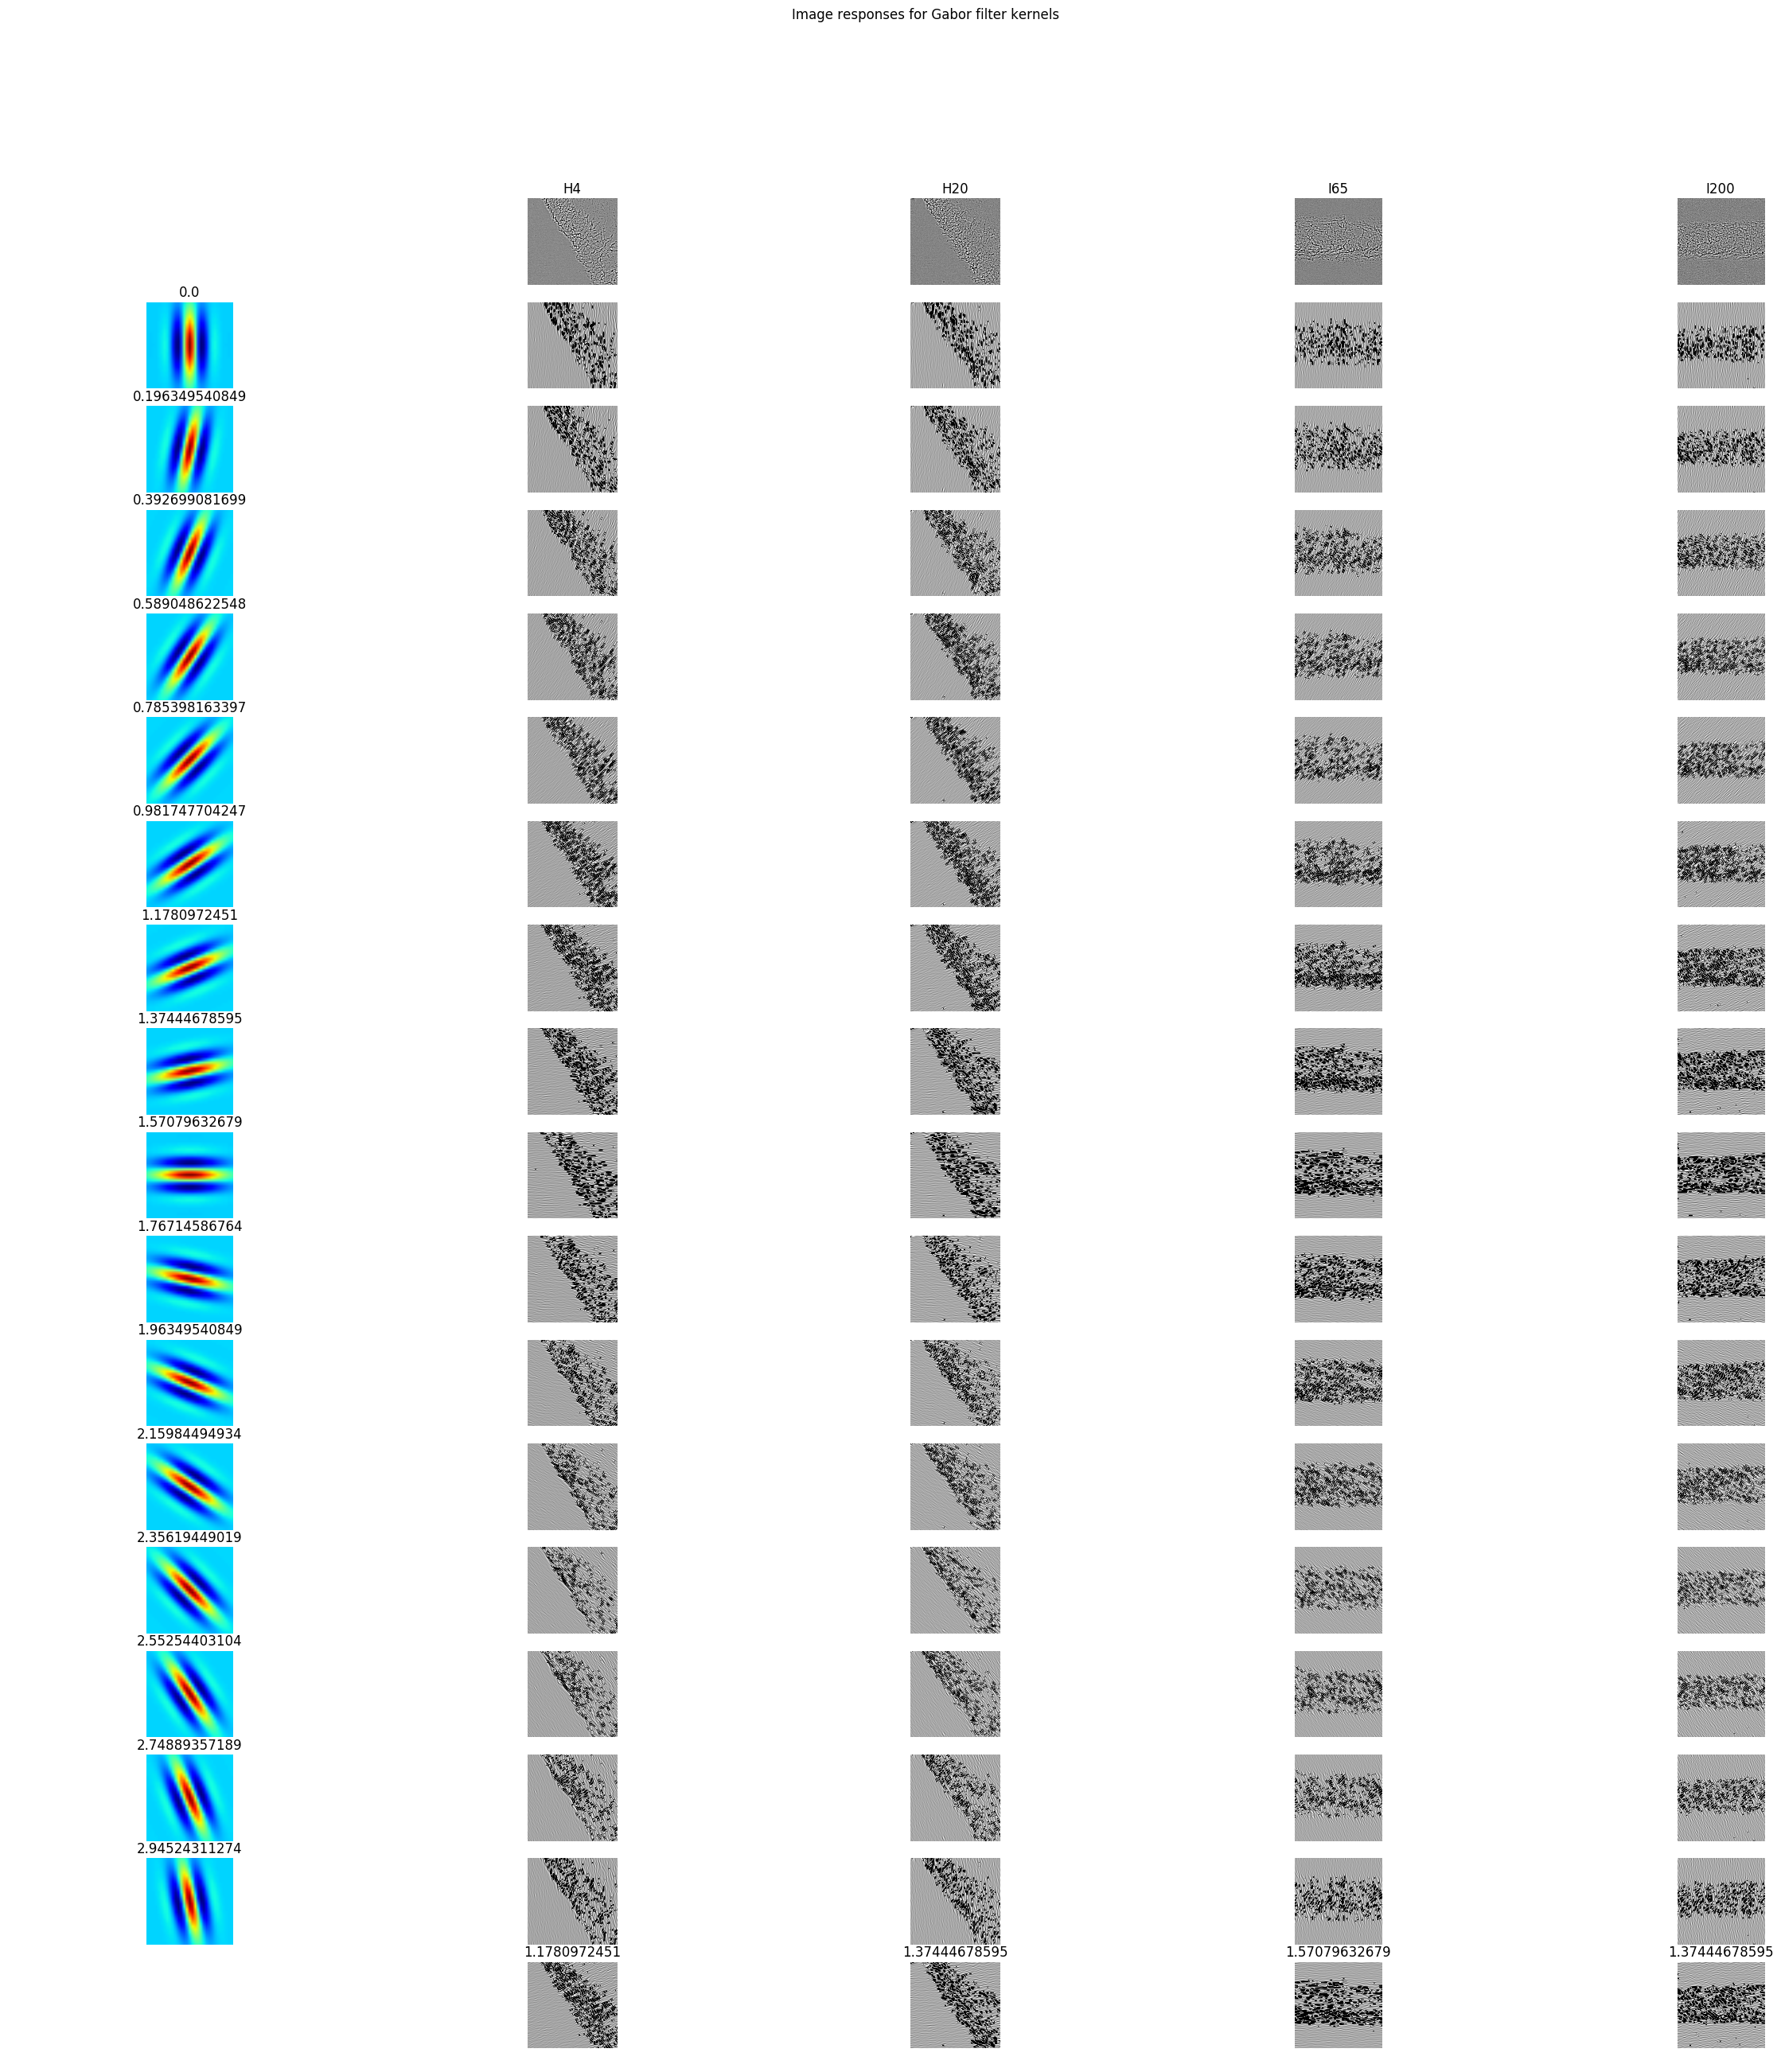

In [17]:


fig, axes = plt.subplots(nrows=len(filters)+2, ncols=len(images)+1,figsize=(30, 30))

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)
axes[0][0].axis('off')
axes[len(filters)+1][0].axis('off')

for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=12)
    ax.axis('off')

for i, flt in enumerate(filters):
    ax = axes[i+1][0]
    ax.set_title(filters_res[i][1], fontsize=12)
    ax.imshow(flt)
    ax.axis('off')

for i ,f_imgS in enumerate(results_by_image): 
    
    max_kern = f_imgS[1]
    for j , f_img  in enumerate(f_imgS[0]):   
        ax = axes[j+1][i+1]
        ax.imshow(f_img)
        ax.axis('off')
    
    ax_1 = axes[-1][i+1]
    ax_1.set_title(filters_res[max_kern][1], fontsize=12)
    ax_1.imshow(f_imgS[0][max_kern])
    ax_1.axis('off')
    
plt.show()

### Display accumulated results

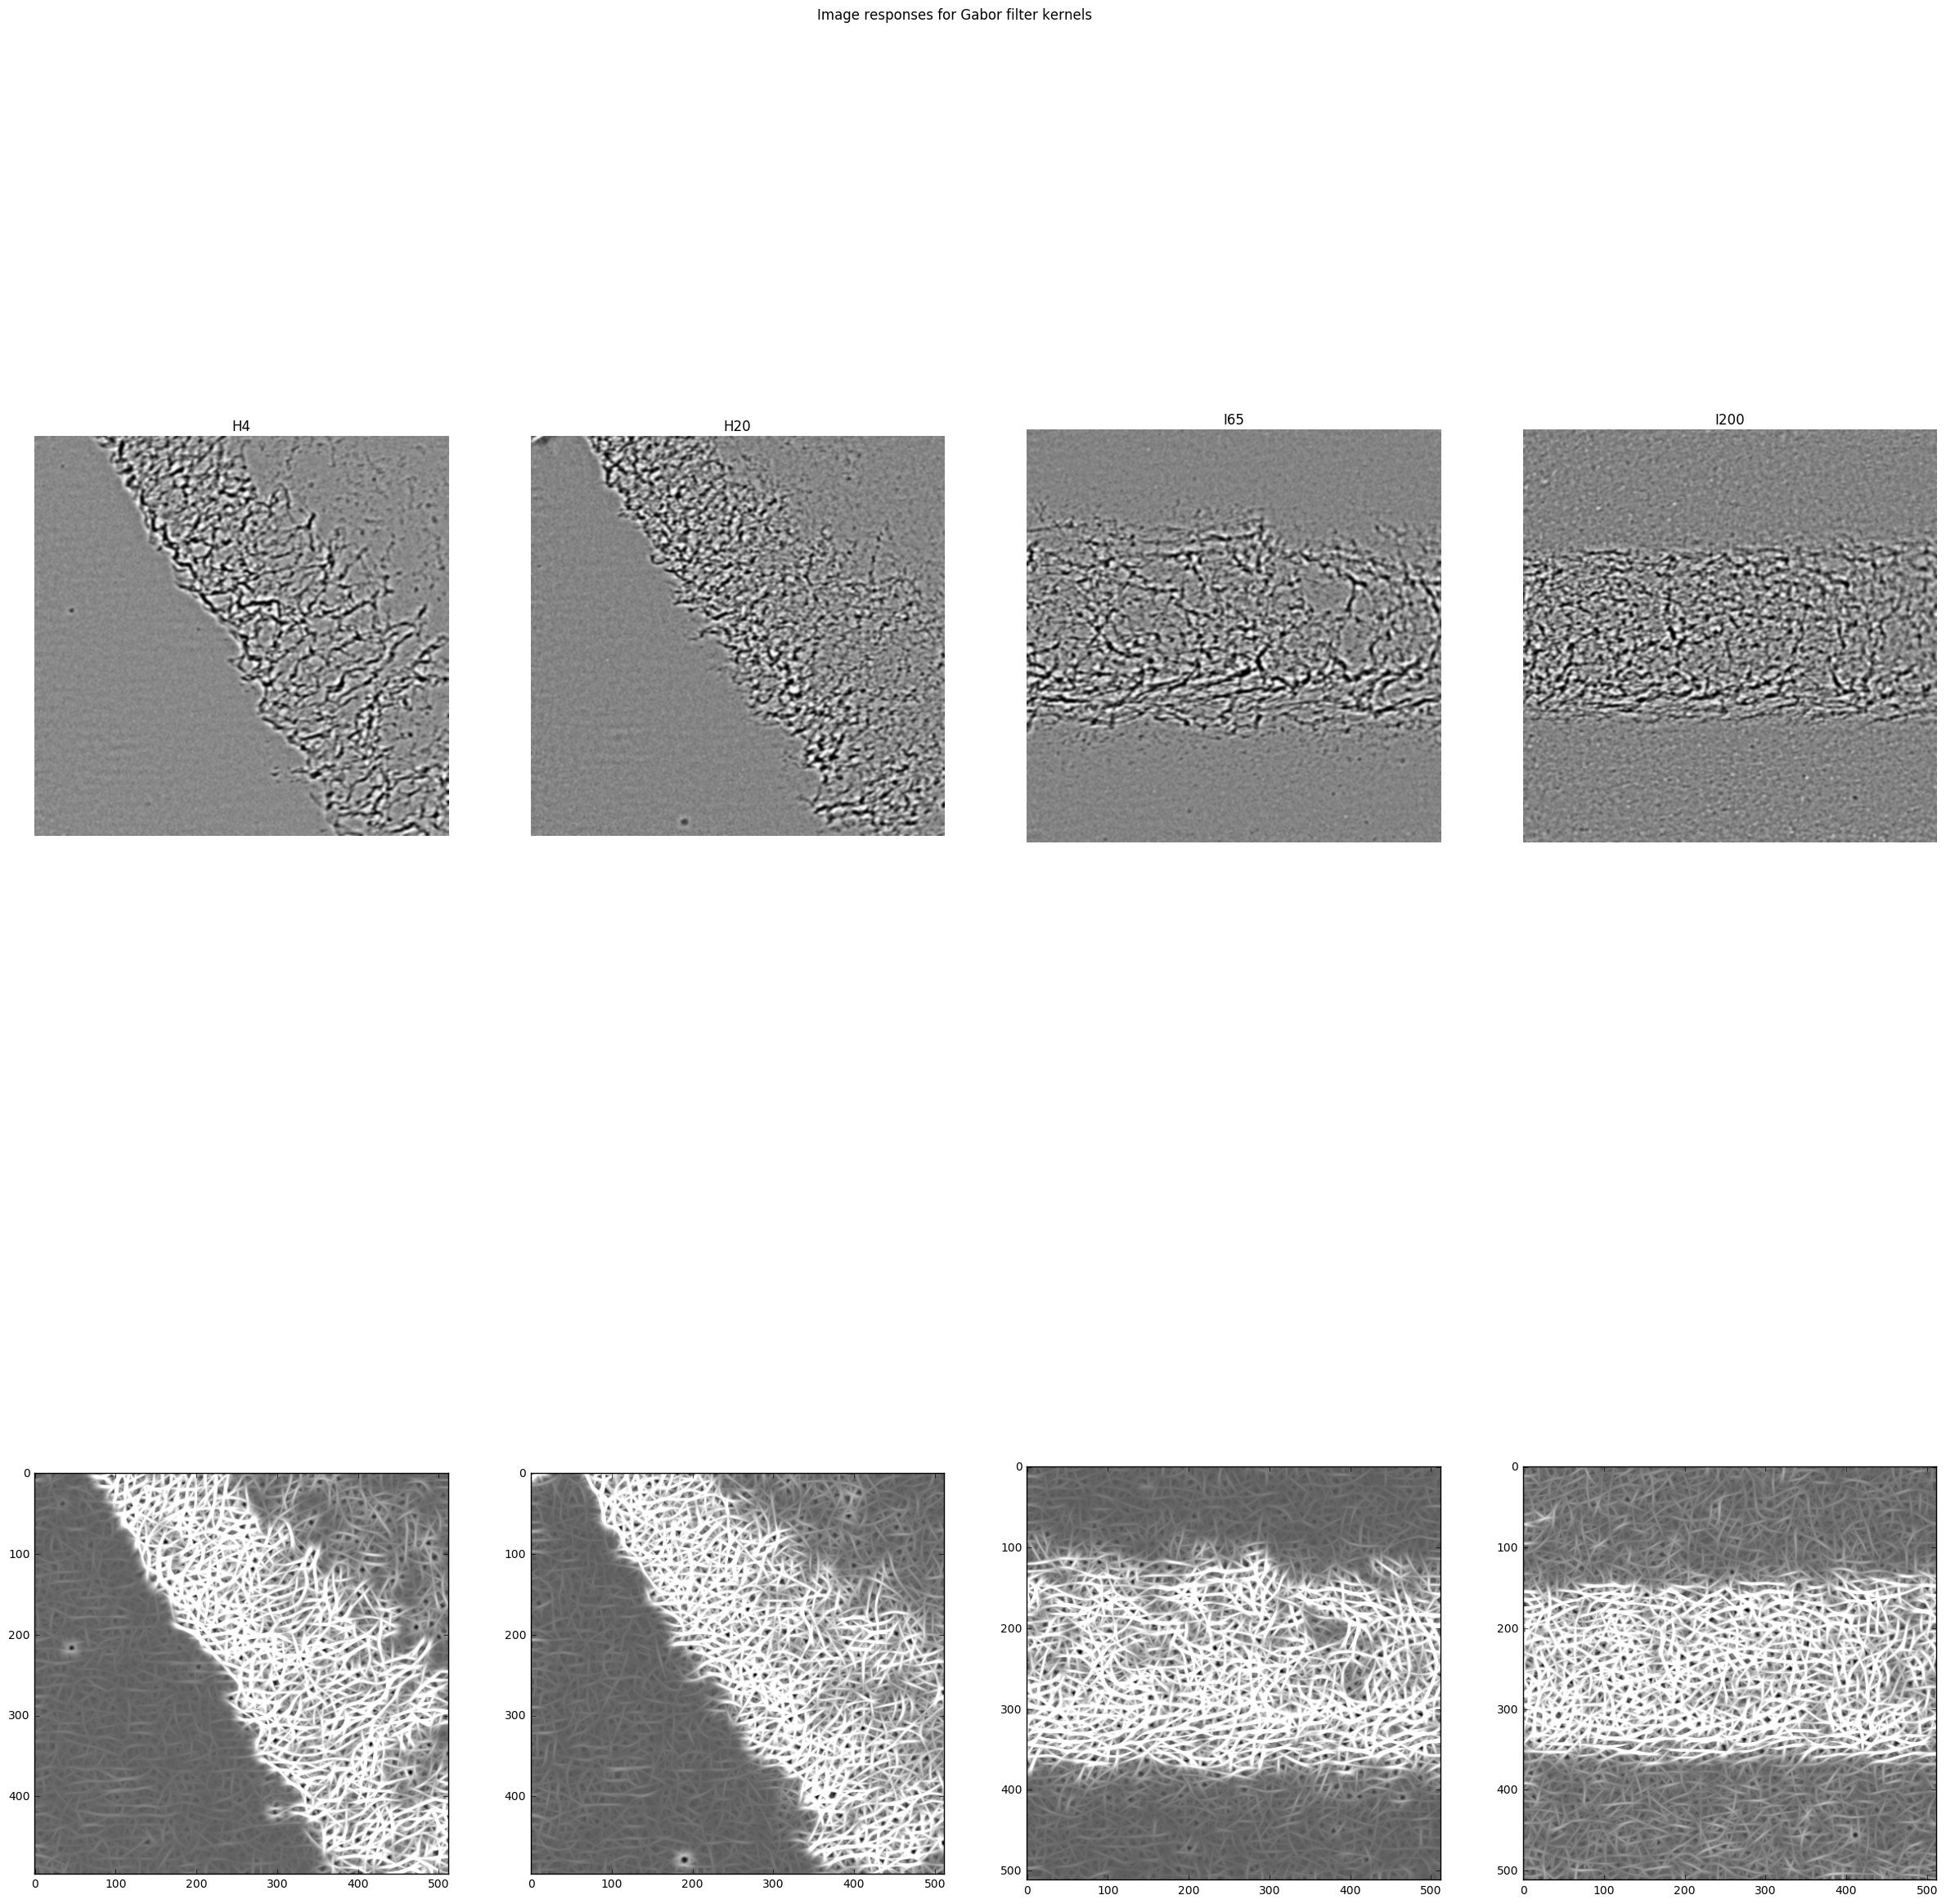

In [325]:
fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(30, 30))

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

for label, img, ax in zip(image_names, images, axes[0][0:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=12)
    ax.axis('off')

for  f_img , ax_row in zip( results , axes[1][0:]):
    ax = ax_row
    ax.imshow(np.real(f_img[0]))
    
    
plt.show()